In [1]:
!pip install scikit-fuzzy matplotlib

You should consider upgrading via the '/home/cristian/venv/RelationExtraction/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from fuzzy_rules import extract_rules,config_input_variable,config_output_variable
from sklearn.metrics import mean_squared_error
from operator import itemgetter
from itertools import groupby
import os
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Read dataset

In [3]:
def read_dataset(file_path):
    def preprocessing(line):
        line = line.strip().replace(',','.')
        return float(line)

    with open(file_path,'r') as file:
        series = [preprocessing(line) for line in file]
    return series

## Configure input output

In [4]:
file_path='Dolar.txt'
windows_size=6
series = read_dataset(file_path)
min_value = min(series)
max_value = max(series)

# nb_outputs: suport only for nb_outputs=1
config = {
'nb_inputs':windows_size,
'nb_outputs':1,
'nb_sets':12,
'min':min_value-0.01,
'max':max_value+0.01,
'resolution':500
}

print(config)

{'nb_inputs': 6, 'nb_outputs': 1, 'nb_sets': 12, 'min': 2.0460000000000003, 'max': 2.4099999999999997, 'resolution': 500}


## Preprocessing dataset

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset = dataset.window(windows_size + 1, shift=1, drop_remainder=True)
data = np.stack([list(window_dataset) for window_dataset in dataset], axis=0)
X,y_true = data[:,:-1],data[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.20, shuffle=False)

print('All data:\t{} {}'.format(X.shape, y.shape))
print('train data:\t{} {}'.format(X_train.shape, y_train.shape))
print('test data:\t{} {}'.format(X_test.shape, y_test.shape))

All data:	(266, 6) (266, 1)
train data:	(212, 6) (212, 1)
test data:	(54, 6) (54, 1)


## Create Fuzzy System

In [9]:
rules = extract_rules(config, X_train, y_train)
system = ctrl.ControlSystem(rules)
sim = ctrl.ControlSystemSimulation(system)

## Test model

mean_squared_error: 0.00017001272802627247


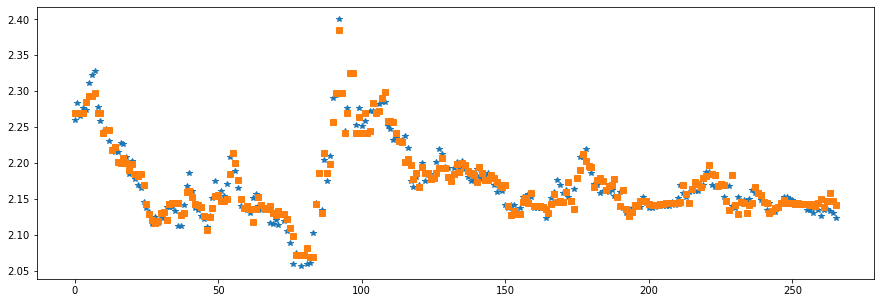

In [14]:
y_prev = []
for x in X:
    for i,x_i in enumerate(x):
        sim.input['i_{}'.format(i+1)]=x_i
    sim.compute()
    y_prev.append(sim.output['o_1'])

mse = mean_squared_error(y_true, y_prev)
print('mean_squared_error: {}'.format(mse))

plt.figure(figsize=(15,5))
plt.plot(y_true,'*')
plt.plot(y_prev,'s')
plt.show()